# Facial Expression Recognition: KDEF Dataset

This notebook contains the code for a facial expression detection algorithm. The data used was acquired from the [The Karolinska Directed Emotional Faces (KDEF)](http://www.emotionlab.se/kdef/).

KDEF is a dataset of 4900 pictures of human facial expressions of emotion.  It was originally developed to be used for psychological and medical research purposes. 

The dataset contains 70 individuals (35 male and 35 female), each displaying 7 different emotional expressions, each expression being photographed (twice) from 5 different angles. The expressions are:
- afraid
- angry
- disgusted
- happy
- neutral
- sad
- surprised

More information on how the data was gathered can be found [here](http://kdef.se/home/aboutKDEF.html).

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai import *
from fastai.vision import *

The data has been downloaded and separated by folder depending the facial expression.  Since we're working on the Google cloud, each folder has been uploaded as a zip file and then unzipped using the command below.

In [9]:
# This command is run for every folder/ category
import zipfile
zip_ref = zipfile.ZipFile('data/KDEF/Surprized.zip', 'r')
zip_ref.extractall('data/KDEF')
zip_ref.close()


# Preparing The Data For Training

In [6]:
#create primary path for the model
path = Path('data/KDEF')

In [16]:
# The contents inside the path folder
path.ls()

[PosixPath('data/KDEF/Disgusted'),
 PosixPath('data/KDEF/Angry'),
 PosixPath('data/KDEF/Neutral'),
 PosixPath('data/KDEF/Surprized'),
 PosixPath('data/KDEF/Happy'),
 PosixPath('data/KDEF/Afraid'),
 PosixPath('data/KDEF/.ipynb_checkpoints'),
 PosixPath('data/KDEF/Sad')]

In [7]:
# Categories or classes
classes = ['Afraid', 'Angry', 'Disgusted', 'Happy', 'Neutral', 'Sad', 'Surprised']

In [21]:
# Now we verify that we can read the imagess inside each folder that describes its class
for i in classes:
    print(i)
    verify_images(path/i, delete=True, max_workers=8)

Afraid


Angry


Disgusted


Happy


Neutral


Sad


Surprised


# View Data

In [8]:
# We use the ImageDataBunch class from the fastai library
# We use a train/ validation ratio of 20%. We have 700 images per class overall so 
# 560 are used for training and 140 for validation for each class
# We set a batch size of 64 to start, but we can lower ot later if we run out of memory
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4, bs=64).normalize(imagenet_stats)

In [42]:
# Now we verify the class defined and the size of the train and validation datasets
data.classes, len(data.train_ds), len(data.valid_ds)

(['Afraid', 'Angry', 'Disgusted', 'Happy', 'Neutral', 'Sad', 'Surprised'],
 3920,
 980)

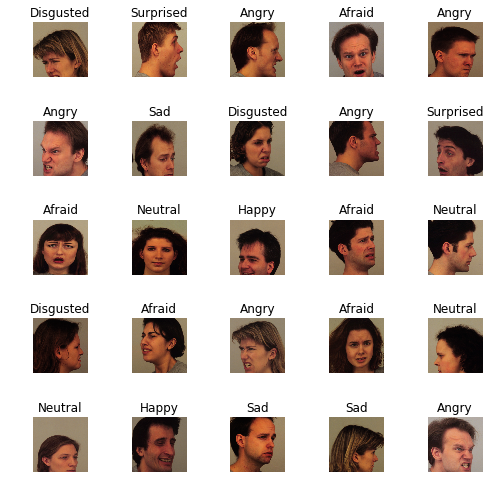

In [44]:
data.show_batch(rows=5, figsize=(7,7))

# Train Model

In [9]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

The architecture used for this model is ResNet-50, which is a model pre-trained  on ImageNet.

In [7]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy
1,2.085771,1.534834,0.419388
2,1.733726,1.341805,0.493878
3,1.468053,1.095873,0.590816
4,1.206825,0.941102,0.643878
5,1.044697,0.809203,0.698980
6,0.917962,0.729220,0.731633
7,0.811776,0.678346,0.742857
8,0.751528,0.622093,0.777551
9,0.699081,0.609446,0.779592
10,0.673502,0.603671,0.783673


After training for 10 epochs, the accuracy is only 78%. We save the model at this stage.

In [11]:
learn.save('kdef-stage-1')

In [14]:
# Then unfreeze and plot the loss vs learning rate
learn.unfreeze()

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


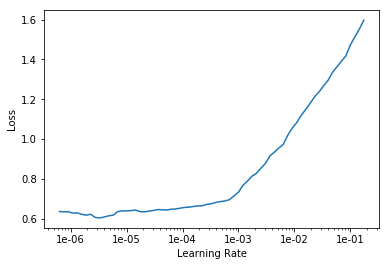

In [15]:
learn.recorder.plot()

We train the model again, using the learning rate at the steepest descent in the graph (5e-5) for the final layers and a small learning rate for the initial laers, since those layers have been pre-trained already.

In [16]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,5e-5))

epoch,train_loss,valid_loss,accuracy
1,0.667126,0.583869,0.795918
2,0.634911,0.553209,0.808163
3,0.585399,0.506810,0.824490
4,0.566170,0.484574,0.827551
5,0.543917,0.445287,0.841837
6,0.501091,0.431518,0.846939
7,0.459510,0.418807,0.851020
8,0.448566,0.409367,0.860204
9,0.439905,0.405639,0.864286
10,0.440894,0.410817,0.853061


After 10 epochs the accuracy is 86.4%.

In [18]:
learn.save('kdef-stage-2')

# Interpretation

We plot the confussion matrix and the top losses to see how the train vs the validation data performed.

In [10]:
learn.load('kdef-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (3920 items)
[Category Disgusted, Category Disgusted, Category Disgusted, Category Disgusted, Category Disgusted]...
Path: data/KDEF
x: ImageItemList (3920 items)
[Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562)]...
Path: data/KDEF;

Valid: LabelList
y: CategoryList (980 items)
[Category Sad, Category Surprised, Category Angry, Category Sad, Category Surprised]...
Path: data/KDEF
x: ImageItemList (980 items)
[Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562)]...
Path: data/KDEF;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Se

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

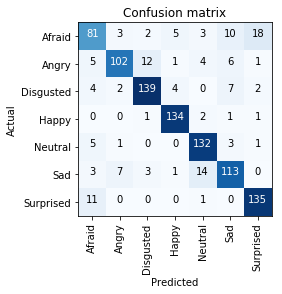

In [22]:
interp.plot_confusion_matrix()

In [23]:
# A list of the most confused classes from most to least
interp.most_confused(min_val=3)

[('Afraid', 'Surprised', 18),
 ('Sad', 'Neutral', 14),
 ('Angry', 'Disgusted', 12),
 ('Surprised', 'Afraid', 11),
 ('Afraid', 'Sad', 10),
 ('Disgusted', 'Sad', 7),
 ('Sad', 'Angry', 7),
 ('Angry', 'Sad', 6),
 ('Afraid', 'Happy', 5),
 ('Angry', 'Afraid', 5),
 ('Neutral', 'Afraid', 5),
 ('Angry', 'Neutral', 4),
 ('Disgusted', 'Afraid', 4),
 ('Disgusted', 'Happy', 4)]

The model has the most trouble differing between an afraid and a surprized facial expression.  

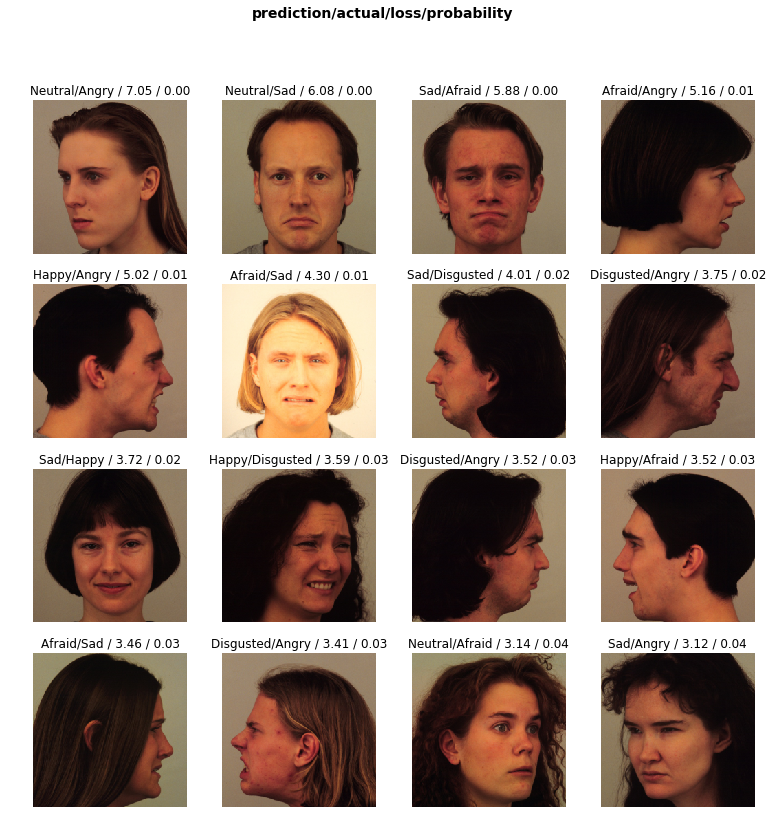

In [28]:
interp.plot_top_losses(16, figsize=(13,13))
# In the pictures below the labels represent:
# what the model predicted/ the actual answer/ the loss/ the probablity of the predicted calls

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

First we need to get the file paths from our top_losses. Here's a handy function that pulls out all our top_losses:

In [2]:
from fastai.widgets import *

In [19]:
#ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Vaild)

In [14]:
ImageCleaner(ds, idxs, batch_size=10)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

After cleaning some images in the validations dataset, we train the model again to see if we can improve the accuracy

In [20]:
np.random.seed(42)
cleaned_data = ImageDataBunch.from_folder(path, train="./kdef", valid_pct=0.2, 
                                      ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)



In [22]:
learn2 = create_cnn(cleaned_data, models.resnet50, metrics=accuracy)

In [23]:
# Load the second stage weights and then re-train the model.
learn2.load('kdef-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (3920 items)
[Category Disgusted, Category Disgusted, Category Disgusted, Category Disgusted, Category Disgusted]...
Path: data/KDEF
x: ImageItemList (3920 items)
[Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562)]...
Path: data/KDEF;

Valid: LabelList
y: CategoryList (980 items)
[Category Sad, Category Surprised, Category Angry, Category Sad, Category Surprised]...
Path: data/KDEF
x: ImageItemList (980 items)
[Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562)]...
Path: data/KDEF;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Se

In [25]:
learn2.unfreeze()
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


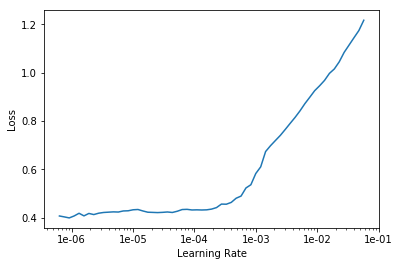

In [26]:
learn2.recorder.plot()

This is a very strange loss vs learning rate graph. It seems that the loss is diverving from the beginning.

In [27]:
learn2.fit_one_cycle(5, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy
1,0.426470,0.399523,0.860204
2,0.422697,0.395493,0.862245
3,0.402327,0.386110,0.867347
4,0.394555,0.377689,0.861224
5,0.394996,0.380288,0.863265


The accuracy didn't improve much. So now we'll try using lower learning rates

In [30]:
learn2.fit_one_cycle(5, max_lr=slice(1e-8,1e-7))

epoch,train_loss,valid_loss,accuracy
1,0.367743,0.375686,0.865306
2,0.381436,0.371735,0.861224
3,0.383812,0.375868,0.861224
4,0.382539,0.369263,0.865306
5,0.381274,0.373079,0.869388


The accuracy didn't improve that much. Plus, the training loss is higher than the validation loss which means that the model could be underfitting. Let's run the model with more epochs and see how it behaves.

In [32]:
learn2.fit_one_cycle(20, max_lr=slice(1e-8,1e-7))

epoch,train_loss,valid_loss,accuracy
1,0.322447,0.339264,0.884694
2,0.330351,0.338804,0.884694
3,0.338738,0.340888,0.884694
4,0.327592,0.335143,0.884694
5,0.327793,0.335753,0.884694
6,0.346080,0.345386,0.879592
7,0.334567,0.337423,0.886735
8,0.336312,0.343908,0.879592
9,0.328344,0.336323,0.882653
10,0.328330,0.334506,0.889796


The model has improved a little bit more. The best accuracy achieved was 88.9%. We will now save this model and use it to build a web application. The web app was deployed following [this guide](https://github.com/nikhilno1/healthy-or-not/blob/master/heroku-deploy.md), using Heroku and creating a Dockerfile.

One important thing to note about this dataset is that it was created using young Caucasian men and women. So if you try to make a prediction using older people or people with other skin tones, your results may not be as accurate.

In [34]:
learn2.save('kdef-stage-3')

In [35]:
learn2.fit_one_cycle(1, max_lr=slice(1e-8,1e-7))

epoch,train_loss,valid_loss,accuracy
1,0.325052,0.335505,0.886735
